# RLify Getting started
In this file we will see examples of running differnet agent-algorithms, getting the train metric, and watching the agents in actions.


In [1]:
%matplotlib inline
from rlify.agents.dqn_agent import DQN_Agent
from rlify.agents.ppo_agent import PPO_Agent
from rlify.agents.ddpg_agent import DDPG_Agent
from rlify.models import fc, rnn
from rlify import utils
import torch
import gymnasium as gym
device = utils.init_torch() #default goes to cuda -> cpu or enter manualy

## Example 1 - Train using discrete PPO
lets train a LunaLander gym env

In [2]:
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode=None)
models_shapes = PPO_Agent.get_models_input_output_shape(env.observation_space, env.action_space)
policy_input_shape = models_shapes["policy_nn"]["input_shape"]
policy_out_shape = models_shapes["policy_nn"]["out_shape"]
critic_input_shape = models_shapes["critic_nn"]["input_shape"]
critic_out_shape = models_shapes["critic_nn"]["out_shape"]
policy_nn = fc.FC(input_shape=policy_input_shape, embed_dim=64, depth=2, activation=torch.nn.ReLU(), out_shape=policy_out_shape)
critic_nn = fc.FC(input_shape=critic_input_shape, embed_dim=64, depth=2, activation=torch.nn.ReLU(), out_shape=critic_out_shape)

agent = PPO_Agent(
        obs_space=env.observation_space, action_space=env.action_space, device=device, batch_size=1024, max_mem_size=10**5, num_parallel_envs=4,
        lr=3e-4, entropy_coeff=0.05, policy_nn=policy_nn, critic_nn=critic_nn, discount_factor=0.99,  kl_div_thresh=0.05, clip_param=0.2,tensorboard_dir="./tensorboard/")
train_stats = agent.train_n_steps(env=env,n_steps=350000)
# Saving the agent ckpt is easy
_ = agent.save_agent('lunar_ppo.pt')

episode 724, curr_mean_R:00083.35, best_mean_R:173.59, total_steps:351626: : 351626it [06:16, 933.92it/s]                           


### Plot rewards collected

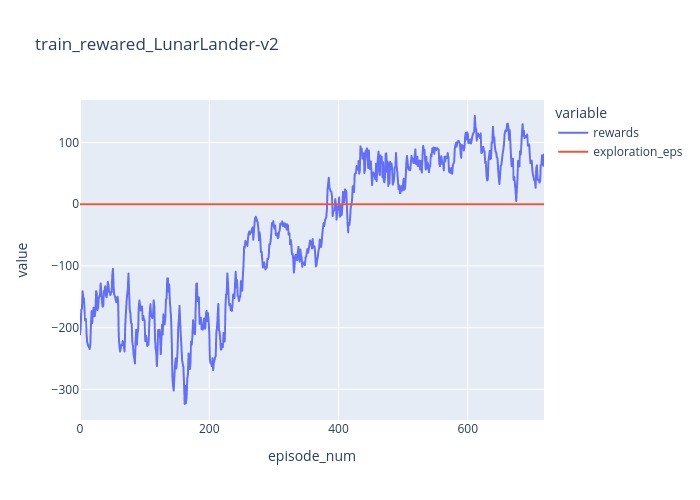

In [3]:
utils.plot_res(train_stats, 'train_rewared_'+env_name, smooth_kernel=10, render_as='jpg') #supports notebook, browser as well

### Lets see our agent in action

In [4]:
# Loading the agent ckpt is easy
agent.load_agent("lunar_ppo.pt")
env = gym.make("LunarLander-v2", render_mode="human")
reward_stats = agent.run_env(env, best_act=True, num_runs=1)
print("Run Reward:", reward_stats)

Run Reward: {'mean': 179.90092926878958, 'std': 0.0, 'all_runs': array([[179.90092927]])}


In [ ]:
#  load the agent
checkpoint = torch.load('lunar_ppo.pt', map_location="cpu")

## Example 2 - Lets use DQN now.
On CartPole

In [6]:
env_name = "CartPole-v1"
env = gym.make(env_name, render_mode=None)
models_shapes = DQN_Agent.get_models_input_output_shape(env.observation_space, env.action_space)
Q_input_shape = models_shapes["Q_model"]["input_shape"]
Q_out_shape = models_shapes["Q_model"]["out_shape"]
Q_model = fc.FC(input_shape=Q_input_shape, out_shape=Q_out_shape)
agent = DQN_Agent(obs_space=env.observation_space, action_space=env.action_space, batch_size=64, max_mem_size=10**5, num_parallel_envs=16,
                     lr=3e-4, Q_model=Q_model, discount_factor=0.99, target_update='hard[update_freq=10]', tensorboard_dir = None, num_epochs_per_update=2)
train_stats = agent.train_n_steps(env=env,n_steps=200000)

episode 3776, curr_mean_R:00165.94, best_mean_R:219.19, total_steps:200032: : 200032it [06:38, 501.85it/s]                           


### Plot rewards collected

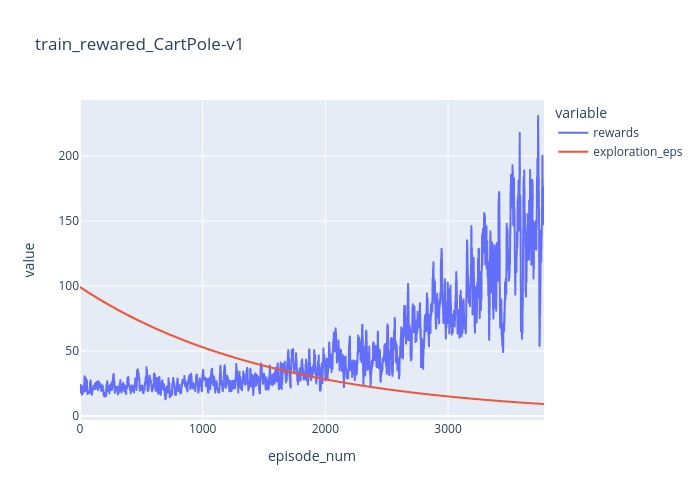

In [7]:
utils.plot_res(train_stats, 'train_rewared_'+env_name, smooth_kernel=10, render_as='jpg')

### Get the metrics for out train - notice that all the metrics are also stored under ./tensorboard dir

In [8]:
metric_df = agent.get_train_metrics()
metric_df.plot(backend='plotly')

## Example 3 -  Lets check a reccurent policy using simple GRU, also its a continious action space environment

In [9]:
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode=None)
# this time we will use a simple GRU as our reccurent NN:
models_shapes = DDPG_Agent.get_models_input_output_shape(env.observation_space, env.action_space)
q_model_input_shape = models_shapes["Q_model"]["input_shape"]
q_model_out_shape = models_shapes["Q_model"]["out_shape"]
q_mle_model_input_shape = models_shapes["Q_mle_model"]["input_shape"]
q_mle_model_out_shape = models_shapes["Q_mle_model"]["out_shape"]
Q_model = rnn.GRU(input_shape=q_model_input_shape, hidden_dim=64, num_grus=2, out_shape=q_model_out_shape)
Q_mle_model = rnn.GRU(input_shape=q_mle_model_input_shape, hidden_dim=64, num_grus=2, out_shape=q_mle_model_out_shape)
agent = DDPG_Agent(obs_space=env.observation_space, action_space=env.action_space, device=device, batch_size=1024, max_mem_size=10**6, num_parallel_envs=16,
                   lr=3e-4, Q_model=Q_model, Q_mle_model=Q_mle_model, discount_factor=0.99, tensorboard_dir = None)
train_stats = agent.train_n_steps(env=env,n_steps=800000)

episode 3984, curr_mean_R:-1398.41, best_mean_R:-1110.98, total_steps:800000: 100%|██████████| 800000/800000 [08:35<00:00, 1552.45it/s]


### Plot rewards collected

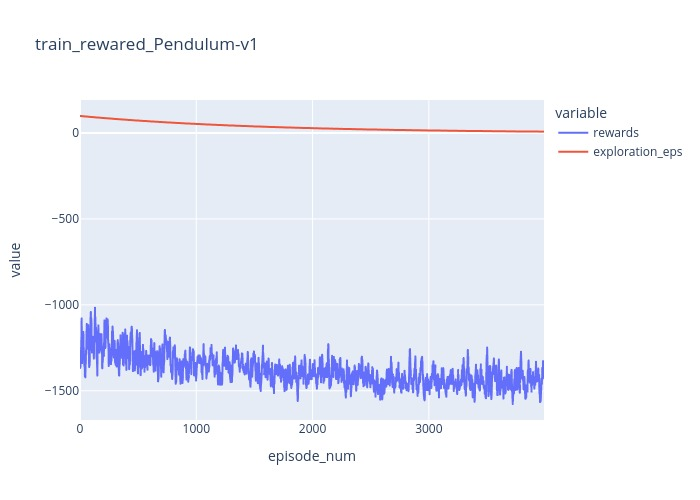

In [10]:
utils.plot_res(train_stats, 'train_rewared_'+env_name, smooth_kernel=10, render_as='jpg') #supports browser as well

### Check Our Agent

In [ ]:
env = gym.make(env_name, render_mode="human")
reward_stats = agent.run_env(env, best_act=True, num_runs=1)
print("Run Reward:", reward_stats)